In [491]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import random
random.seed(123)
import warnings
warnings.filterwarnings("ignore")
import os
from sklearn import preprocessing
import matplotlib.pyplot as plt
from tqdm import tqdm
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [492]:
def clean_reformat(dataset):
    dataset.loc[dataset.PossessionTeam == 'ARZ', 'PossessionTeam'] = 'ARI'
    dataset.loc[dataset.PossessionTeam == 'BLT', 'PossessionTeam'] = 'BAL'
    dataset.loc[dataset.PossessionTeam == 'CLV', 'PossessionTeam'] = 'CLE'
    dataset.loc[dataset.PossessionTeam == 'HST', 'PossessionTeam'] = 'HOU'
    dataset.loc[dataset.PossessionTeam == 'ARZ', 'FieldPosition'] = 'ARI'
    dataset.loc[dataset.PossessionTeam == 'BLT', 'FieldPosition'] = 'BAL'
    dataset.loc[dataset.PossessionTeam == 'CLV', 'FieldPosition'] = 'CLE'
    dataset.loc[dataset.PossessionTeam == 'HST', 'FieldPosition'] = 'HOU'
    dataset[['X', 'Y', 'S', 'A', 'Orientation']] = dataset[['X', 'Y', 'S', 'A', 'Orientation']].fillna(0)
    fraction = [1, 1/60, 0]
    dataset['TimeRemained'] = dataset.GameClock.apply(lambda x: sum([a*b for a, b in zip(fraction, map(int, x.split(':')))]))
    dataset['DefendersInTheBox'] = dataset['DefendersInTheBox'].fillna(value = 7) # most common value
    # dataset['GameSnap'] = dataset['GameId'].map(str) + dataset['TimeSnap'].map(str)
    # dataset['GameSnap'] = dataset['PlayId'].map(str)
    # dataset['TimeHandoff'] = pd.to_datetime(dataset['TimeHandoff'], format = "%Y-%m-%dT%H:%M:%S")
    # dataset['TimeSnap'] = pd.to_datetime(dataset['TimeSnap'], format = "%Y-%m-%dT%H:%M:%S")
    # # WindSpeed and WindDirection are switched for some rows in the dataset, the following script is used to switch them back to the sampe spot
    # mask = dataset['WindDirection'].map(lambda x: str(x).isnumeric()) & (dataset['WindSpeed'].map(lambda x: not str(x).isnumeric()))
    # wrong_ds = dataset[mask]
    # dataset.loc[mask, 'WindDirection'] = wrong_ds['WindSpeed']
    # dataset.loc[mask, 'WindSpeed'] = wrong_ds['WindDirection'].astype(int)
    # dataset['WindSpeed'] = dataset['WindSpeed'].apply(lambda x: numerize(x))
    # dataset['Stadium'] = dataset['Stadium'].str.replace('Stadium', '')
    # dataset['Stadium'] = dataset['Stadium'].str.strip()   # remove the leading spaces from the rows
    # dataset['WindSpeed'] = dataset['WindSpeed'].astype(str).str.replace('(mph|MPH|MPh|-.*|g.*)', '')
    # dataset['WindSpeed'] = dataset['WindSpeed'].astype(str).str.strip()
    # dataset.loc[dataset.WindSpeed == 'Calm', 'WindSpeed'] = '0'
    return dataset


In [503]:
dataset.columns

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'Yards', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'TimeRemained',
       'IsRusher', 'OffenseDefense'],
      dtype='object')

In [493]:
# metadata
subset_rate, test_portion = 0.5, 0.2
dataset = pd.read_csv('../datasets/train.csv', low_memory=False)
dataset = clean_reformat(dataset)

In [494]:
def train_test_split(dataset, subset_rate, test_portion):
    game_id = random.sample(list(dataset.GameId.unique()), int(subset_rate * len(dataset.GameId.unique())))
    test_id, train_id = game_id[:int(test_portion * len(game_id))], game_id[int(test_portion * len(game_id)):]
    train_plays = dataset.loc[dataset.GameId.isin(train_id), 'PlayId'].unique()
    test_plays = dataset.loc[dataset.GameId.isin(test_id), 'PlayId'].unique()
    # x_train, y_train = transform_train_test(train_plays)
    # x_test, y_test = transform_train_test(test_plays)
    return train_plays, test_plays


In [495]:
train_playid, test_playid = train_test_split(dataset, subset_rate = subset_rate, test_portion = test_portion)

In [498]:
def engineer_rusher_feature(dataset, play_id_list, is_train = True, is_submission = False, scaler = None, ohe = None):
    dataset['IsRusher'] = False
    dataset.loc[dataset.NflId == dataset.NflIdRusher, 'IsRusher'] = True
    # dataset['OffenseDefense'] = 'D'
    dataset['OffenseDefense'] = np.where((dataset.PossessionTeam == dataset.HomeTeamAbbr) & \
                                        (dataset.Team == 'home'), 'O', 
                                    np.where((dataset.PossessionTeam == dataset.VisitorTeamAbbr) & \
                                            (dataset.Team == 'away'), 'O', 'D'))
    cols_to_scale = ['X', 'Y', 'S', 'A', 'Orientation', 'Distance', 'Quarter', 'TimeRemained',
                    'Down', 'DefendersInTheBox']
    cols_to_ohe = ['HomeTeamAbbr', 'VisitorTeamAbbr', 'PossessionTeam']
    if is_train:
        scaler = preprocessing.MinMaxScaler()
        dataset[cols_to_scale] = scaler.fit_transform(dataset[cols_to_scale])
        ohe = preprocessing.OneHotEncoder(handle_unknown = 'ignore')
        ohe.fit(dataset[cols_to_ohe])
    else:
        dataset[cols_to_scale] = scaler.transform(dataset[cols_to_scale])
    X = []
    Y = []
    for play_id in tqdm(play_id_list):
        game_data = dataset[dataset.PlayId == play_id]
        cols_to_dl = ['PlayId', 'X', 'Y', 'S', 'A', 'Orientation', 'IsRusher', 'OffenseDefense', 'PlayDirection', 'Yards']
        spatial_data = game_data[cols_to_dl]
        rusher_data = spatial_data[spatial_data.IsRusher]
        if spatial_data.PlayDirection.values[0] == 'right':
            spatial_data[['X', 'Y']] = spatial_data[['X', 'Y']].values - rusher_data[['X', 'Y']].values
        else:
            spatial_data[['X', 'Y']] = rusher_data[['X', 'Y']].values - spatial_data[['X', 'Y']].values
        spatial_data['RusherDistance'] = np.sqrt(np.square(spatial_data.X) + np.square(spatial_data.Y))
        spatial_data = spatial_data.sort_values(by = ['OffenseDefense', 'RusherDistance'])
        OH_array = ohe.transform(game_data[:1][cols_to_ohe]).toarray()
        dl_input = list(pd.concat([spatial_data.X, spatial_data.Y, spatial_data.S, spatial_data.A, 
                                  spatial_data.Orientation, spatial_data.RusherDistance]))
        dl_input.extend([game_data.Distance.values[0], game_data.Quarter.values[0], game_data.TimeRemained.values[0],
                        game_data.Down.values[0], game_data.DefendersInTheBox.values[0]])
        dl_input.extend(OH_array[0])
        X.append(dl_input)
#         dl_output = []
#         dl_output[:199] = [0] * 199
#         dl_output[(99 + int(spatial_data.Yards.values[0])):] = 1
#         Y.append(dl_output)
        if is_submission == False:
            Y.append(99+int(spatial_data.Yards.values[0]))
    return torch.FloatTensor(X), torch.tensor(Y, dtype=torch.long), scaler, ohe


In [499]:
model_x, model_y, scaler, one_hot = engineer_rusher_feature(dataset = dataset, play_id_list = train_playid)
valid_x, valid_y, _, _ = engineer_rusher_feature(dataset = dataset, play_id_list = test_playid, is_train = False, 
                                                 scaler = scaler, ohe = one_hot)




  0%|          | 0/9192 [00:00<?, ?it/s]


  0%|          | 7/9192 [00:00<02:17, 66.76it/s]


  0%|          | 14/9192 [00:00<02:18, 66.45it/s]


  0%|          | 20/9192 [00:00<02:27, 62.38it/s]


  0%|          | 26/9192 [00:00<02:30, 60.75it/s]


  0%|          | 32/9192 [00:00<02:36, 58.47it/s]


  0%|          | 38/9192 [00:00<02:39, 57.45it/s]


  0%|          | 43/9192 [00:00<03:03, 49.91it/s]


  1%|          | 48/9192 [00:00<03:16, 46.51it/s]


  1%|          | 55/9192 [00:01<03:02, 50.02it/s]


  1%|          | 60/9192 [00:01<03:15, 46.79it/s]


  1%|          | 65/9192 [00:01<03:19, 45.71it/s]


  1%|          | 70/9192 [00:01<03:38, 41.66it/s]


  1%|          | 75/9192 [00:01<03:50, 39.50it/s]


  1%|          | 81/9192 [00:01<03:29, 43.46it/s]


  1%|          | 88/9192 [00:01<03:06, 48.90it/s]


  1%|          | 95/9192 [00:01<02:49, 53.73it/s]


  1%|          | 103/9192 [00:01<02:36, 58.02it/s]


  1%|          | 111/9192 [00:02<02:27, 61.56it/s]


  1%|▏         | 

  7%|▋         | 684/9192 [00:16<02:54, 48.66it/s]


  7%|▋         | 689/9192 [00:16<02:57, 47.99it/s]


  8%|▊         | 694/9192 [00:17<03:05, 45.72it/s]


  8%|▊         | 699/9192 [00:17<03:03, 46.17it/s]


  8%|▊         | 705/9192 [00:17<02:51, 49.48it/s]


  8%|▊         | 712/9192 [00:17<02:39, 53.07it/s]


  8%|▊         | 719/9192 [00:17<02:31, 55.87it/s]


  8%|▊         | 725/9192 [00:17<02:31, 55.91it/s]


  8%|▊         | 732/9192 [00:17<02:27, 57.53it/s]


  8%|▊         | 739/9192 [00:17<02:22, 59.14it/s]


  8%|▊         | 746/9192 [00:17<02:19, 60.64it/s]


  8%|▊         | 753/9192 [00:18<02:18, 61.05it/s]


  8%|▊         | 760/9192 [00:18<02:19, 60.29it/s]


  8%|▊         | 767/9192 [00:18<02:19, 60.20it/s]


  8%|▊         | 774/9192 [00:18<02:18, 60.73it/s]


  8%|▊         | 781/9192 [00:18<02:17, 61.20it/s]


  9%|▊         | 788/9192 [00:18<02:15, 62.17it/s]


  9%|▊         | 795/9192 [00:18<02:20, 59.66it/s]


  9%|▊         | 801/9192 [00:18<03:09, 44.27i

 17%|█▋        | 1524/9192 [00:32<01:54, 67.00it/s]


 17%|█▋        | 1531/9192 [00:32<01:53, 67.63it/s]


 17%|█▋        | 1538/9192 [00:32<01:53, 67.51it/s]


 17%|█▋        | 1545/9192 [00:32<01:55, 66.35it/s]


 17%|█▋        | 1552/9192 [00:32<01:54, 66.68it/s]


 17%|█▋        | 1559/9192 [00:32<01:56, 65.41it/s]


 17%|█▋        | 1566/9192 [00:33<01:56, 65.23it/s]


 17%|█▋        | 1573/9192 [00:33<01:56, 65.51it/s]


 17%|█▋        | 1580/9192 [00:33<01:56, 65.54it/s]


 17%|█▋        | 1587/9192 [00:33<01:57, 64.88it/s]


 17%|█▋        | 1594/9192 [00:33<01:54, 66.25it/s]


 17%|█▋        | 1601/9192 [00:33<01:54, 66.52it/s]


 17%|█▋        | 1608/9192 [00:33<01:54, 66.38it/s]


 18%|█▊        | 1615/9192 [00:33<01:54, 66.46it/s]


 18%|█▊        | 1622/9192 [00:33<01:54, 66.29it/s]


 18%|█▊        | 1629/9192 [00:33<01:53, 66.38it/s]


 18%|█▊        | 1636/9192 [00:34<01:54, 66.13it/s]


 18%|█▊        | 1643/9192 [00:34<01:53, 66.73it/s]


 18%|█▊        | 1650/9192 [

 27%|██▋       | 2443/9192 [00:46<01:39, 68.08it/s]


 27%|██▋       | 2450/9192 [00:46<01:39, 67.90it/s]


 27%|██▋       | 2458/9192 [00:46<01:38, 68.64it/s]


 27%|██▋       | 2465/9192 [00:46<01:37, 68.73it/s]


 27%|██▋       | 2472/9192 [00:46<01:37, 68.66it/s]


 27%|██▋       | 2480/9192 [00:46<01:36, 69.32it/s]


 27%|██▋       | 2487/9192 [00:46<01:36, 69.19it/s]


 27%|██▋       | 2494/9192 [00:46<01:37, 68.58it/s]


 27%|██▋       | 2501/9192 [00:46<01:37, 68.86it/s]


 27%|██▋       | 2508/9192 [00:47<01:36, 68.91it/s]


 27%|██▋       | 2515/9192 [00:47<01:36, 68.89it/s]


 27%|██▋       | 2523/9192 [00:47<01:35, 69.66it/s]


 28%|██▊       | 2530/9192 [00:47<01:36, 69.08it/s]


 28%|██▊       | 2537/9192 [00:47<01:36, 68.89it/s]


 28%|██▊       | 2544/9192 [00:47<01:37, 68.11it/s]


 28%|██▊       | 2552/9192 [00:47<01:36, 69.09it/s]


 28%|██▊       | 2559/9192 [00:47<01:36, 68.66it/s]


 28%|██▊       | 2566/9192 [00:47<01:36, 68.67it/s]


 28%|██▊       | 2573/9192 [

 37%|███▋      | 3367/9192 [00:59<01:24, 68.53it/s]


 37%|███▋      | 3374/9192 [00:59<01:27, 66.24it/s]


 37%|███▋      | 3382/9192 [00:59<01:25, 67.57it/s]


 37%|███▋      | 3389/9192 [00:59<01:25, 67.92it/s]


 37%|███▋      | 3396/9192 [01:00<01:25, 67.41it/s]


 37%|███▋      | 3403/9192 [01:00<01:25, 68.05it/s]


 37%|███▋      | 3410/9192 [01:00<01:25, 67.84it/s]


 37%|███▋      | 3417/9192 [01:00<01:25, 67.64it/s]


 37%|███▋      | 3424/9192 [01:00<01:25, 67.38it/s]


 37%|███▋      | 3432/9192 [01:00<01:23, 68.66it/s]


 37%|███▋      | 3439/9192 [01:00<01:24, 67.97it/s]


 37%|███▋      | 3446/9192 [01:00<01:24, 68.29it/s]


 38%|███▊      | 3453/9192 [01:00<01:24, 68.12it/s]


 38%|███▊      | 3461/9192 [01:01<01:22, 69.05it/s]


 38%|███▊      | 3468/9192 [01:01<01:22, 69.33it/s]


 38%|███▊      | 3475/9192 [01:01<01:22, 69.21it/s]


 38%|███▊      | 3482/9192 [01:01<01:22, 69.04it/s]


 38%|███▊      | 3489/9192 [01:01<01:22, 69.22it/s]


 38%|███▊      | 3497/9192 [

 47%|████▋     | 4291/9192 [01:13<01:13, 66.81it/s]


 47%|████▋     | 4298/9192 [01:13<01:14, 65.87it/s]


 47%|████▋     | 4305/9192 [01:13<01:13, 66.13it/s]


 47%|████▋     | 4312/9192 [01:13<01:14, 65.26it/s]


 47%|████▋     | 4319/9192 [01:13<01:14, 65.82it/s]


 47%|████▋     | 4326/9192 [01:13<01:14, 65.30it/s]


 47%|████▋     | 4333/9192 [01:13<01:14, 65.26it/s]


 47%|████▋     | 4340/9192 [01:14<01:14, 65.32it/s]


 47%|████▋     | 4347/9192 [01:14<01:13, 66.18it/s]


 47%|████▋     | 4354/9192 [01:14<01:13, 65.74it/s]


 47%|████▋     | 4361/9192 [01:14<01:13, 65.74it/s]


 48%|████▊     | 4368/9192 [01:14<01:13, 65.83it/s]


 48%|████▊     | 4375/9192 [01:14<01:12, 66.21it/s]


 48%|████▊     | 4382/9192 [01:14<01:12, 66.47it/s]


 48%|████▊     | 4389/9192 [01:14<01:12, 66.58it/s]


 48%|████▊     | 4396/9192 [01:14<01:11, 67.22it/s]


 48%|████▊     | 4403/9192 [01:15<01:11, 66.53it/s]


 48%|████▊     | 4410/9192 [01:15<01:11, 66.49it/s]


 48%|████▊     | 4417/9192 [

 57%|█████▋    | 5208/9192 [01:26<00:58, 68.26it/s]


 57%|█████▋    | 5215/9192 [01:26<00:58, 68.41it/s]


 57%|█████▋    | 5222/9192 [01:27<00:57, 68.86it/s]


 57%|█████▋    | 5229/9192 [01:27<00:57, 69.03it/s]


 57%|█████▋    | 5236/9192 [01:27<00:57, 69.05it/s]


 57%|█████▋    | 5244/9192 [01:27<00:56, 69.50it/s]


 57%|█████▋    | 5251/9192 [01:27<00:56, 69.36it/s]


 57%|█████▋    | 5258/9192 [01:27<00:56, 69.09it/s]


 57%|█████▋    | 5265/9192 [01:27<00:57, 68.89it/s]


 57%|█████▋    | 5272/9192 [01:27<00:57, 67.76it/s]


 57%|█████▋    | 5279/9192 [01:27<00:57, 67.86it/s]


 58%|█████▊    | 5286/9192 [01:28<00:57, 68.01it/s]


 58%|█████▊    | 5293/9192 [01:28<00:57, 67.96it/s]


 58%|█████▊    | 5300/9192 [01:28<00:56, 68.42it/s]


 58%|█████▊    | 5307/9192 [01:28<00:57, 67.90it/s]


 58%|█████▊    | 5314/9192 [01:28<00:56, 68.37it/s]


 58%|█████▊    | 5321/9192 [01:28<00:56, 68.49it/s]


 58%|█████▊    | 5328/9192 [01:28<00:56, 68.52it/s]


 58%|█████▊    | 5335/9192 [

 67%|██████▋   | 6127/9192 [01:40<00:45, 66.74it/s]


 67%|██████▋   | 6134/9192 [01:40<00:45, 67.18it/s]


 67%|██████▋   | 6141/9192 [01:40<00:44, 67.82it/s]


 67%|██████▋   | 6148/9192 [01:40<00:44, 68.42it/s]


 67%|██████▋   | 6155/9192 [01:40<00:44, 68.58it/s]


 67%|██████▋   | 6162/9192 [01:40<00:45, 66.44it/s]


 67%|██████▋   | 6169/9192 [01:40<00:44, 67.28it/s]


 67%|██████▋   | 6176/9192 [01:41<00:45, 66.79it/s]


 67%|██████▋   | 6183/9192 [01:41<00:44, 67.20it/s]


 67%|██████▋   | 6190/9192 [01:41<00:44, 67.55it/s]


 67%|██████▋   | 6197/9192 [01:41<00:44, 67.89it/s]


 67%|██████▋   | 6204/9192 [01:41<00:44, 67.82it/s]


 68%|██████▊   | 6211/9192 [01:41<00:43, 68.43it/s]


 68%|██████▊   | 6218/9192 [01:41<00:43, 68.37it/s]


 68%|██████▊   | 6226/9192 [01:41<00:42, 69.20it/s]


 68%|██████▊   | 6233/9192 [01:41<00:42, 69.08it/s]


 68%|██████▊   | 6240/9192 [01:42<00:42, 68.88it/s]


 68%|██████▊   | 6248/9192 [01:42<00:42, 69.66it/s]


 68%|██████▊   | 6255/9192 [

 77%|███████▋  | 7047/9192 [01:53<00:31, 67.58it/s]


 77%|███████▋  | 7054/9192 [01:53<00:33, 63.41it/s]


 77%|███████▋  | 7061/9192 [01:54<00:32, 65.20it/s]


 77%|███████▋  | 7068/9192 [01:54<00:31, 66.56it/s]


 77%|███████▋  | 7076/9192 [01:54<00:31, 67.68it/s]


 77%|███████▋  | 7083/9192 [01:54<00:32, 65.25it/s]


 77%|███████▋  | 7090/9192 [01:54<00:31, 66.00it/s]


 77%|███████▋  | 7097/9192 [01:54<00:31, 67.01it/s]


 77%|███████▋  | 7105/9192 [01:54<00:30, 68.46it/s]


 77%|███████▋  | 7112/9192 [01:54<00:30, 68.25it/s]


 77%|███████▋  | 7119/9192 [01:54<00:30, 67.48it/s]


 78%|███████▊  | 7126/9192 [01:55<00:30, 68.12it/s]


 78%|███████▊  | 7133/9192 [01:55<00:30, 68.24it/s]


 78%|███████▊  | 7140/9192 [01:55<00:30, 67.16it/s]


 78%|███████▊  | 7147/9192 [01:55<00:30, 67.26it/s]


 78%|███████▊  | 7155/9192 [01:55<00:29, 68.46it/s]


 78%|███████▊  | 7162/9192 [01:55<00:29, 68.16it/s]


 78%|███████▊  | 7170/9192 [01:55<00:29, 69.11it/s]


 78%|███████▊  | 7177/9192 [

 87%|████████▋ | 7974/9192 [02:07<00:18, 67.15it/s]


 87%|████████▋ | 7981/9192 [02:07<00:18, 67.18it/s]


 87%|████████▋ | 7988/9192 [02:07<00:17, 67.54it/s]


 87%|████████▋ | 7995/9192 [02:07<00:17, 67.92it/s]


 87%|████████▋ | 8002/9192 [02:07<00:17, 68.10it/s]


 87%|████████▋ | 8009/9192 [02:07<00:17, 68.46it/s]


 87%|████████▋ | 8016/9192 [02:08<00:17, 68.60it/s]


 87%|████████▋ | 8024/9192 [02:08<00:16, 69.54it/s]


 87%|████████▋ | 8031/9192 [02:08<00:16, 69.56it/s]


 87%|████████▋ | 8038/9192 [02:08<00:16, 68.75it/s]


 88%|████████▊ | 8045/9192 [02:08<00:16, 69.09it/s]


 88%|████████▊ | 8053/9192 [02:08<00:16, 69.54it/s]


 88%|████████▊ | 8060/9192 [02:08<00:16, 69.25it/s]


 88%|████████▊ | 8067/9192 [02:08<00:16, 68.65it/s]


 88%|████████▊ | 8075/9192 [02:08<00:16, 69.27it/s]


 88%|████████▊ | 8082/9192 [02:09<00:16, 69.13it/s]


 88%|████████▊ | 8089/9192 [02:09<00:15, 69.19it/s]


 88%|████████▊ | 8097/9192 [02:09<00:15, 69.83it/s]


 88%|████████▊ | 8104/9192 [

 97%|█████████▋| 8895/9192 [02:21<00:04, 67.77it/s]


 97%|█████████▋| 8902/9192 [02:21<00:04, 67.44it/s]


 97%|█████████▋| 8909/9192 [02:21<00:04, 67.98it/s]


 97%|█████████▋| 8917/9192 [02:21<00:03, 68.86it/s]


 97%|█████████▋| 8924/9192 [02:21<00:03, 68.45it/s]


 97%|█████████▋| 8931/9192 [02:21<00:03, 68.82it/s]


 97%|█████████▋| 8939/9192 [02:21<00:03, 69.47it/s]


 97%|█████████▋| 8946/9192 [02:21<00:03, 69.12it/s]


 97%|█████████▋| 8953/9192 [02:21<00:03, 65.90it/s]


 97%|█████████▋| 8961/9192 [02:22<00:03, 67.62it/s]


 98%|█████████▊| 8968/9192 [02:22<00:03, 67.86it/s]


 98%|█████████▊| 8975/9192 [02:22<00:03, 68.18it/s]


 98%|█████████▊| 8982/9192 [02:22<00:03, 66.31it/s]


 98%|█████████▊| 8989/9192 [02:22<00:03, 65.98it/s]


 98%|█████████▊| 8996/9192 [02:22<00:02, 66.87it/s]


 98%|█████████▊| 9004/9192 [02:22<00:02, 67.93it/s]


 98%|█████████▊| 9012/9192 [02:22<00:02, 68.88it/s]


 98%|█████████▊| 9020/9192 [02:22<00:02, 69.45it/s]


 98%|█████████▊| 9027/9192 [

 27%|██▋       | 624/2352 [00:09<00:25, 68.70it/s]


 27%|██▋       | 631/2352 [00:09<00:25, 68.55it/s]


 27%|██▋       | 638/2352 [00:09<00:25, 68.41it/s]


 27%|██▋       | 645/2352 [00:09<00:25, 67.85it/s]


 28%|██▊       | 652/2352 [00:09<00:24, 68.39it/s]


 28%|██▊       | 660/2352 [00:09<00:24, 69.04it/s]


 28%|██▊       | 668/2352 [00:09<00:24, 69.77it/s]


 29%|██▊       | 675/2352 [00:09<00:24, 68.11it/s]


 29%|██▉       | 683/2352 [00:10<00:24, 68.79it/s]


 29%|██▉       | 690/2352 [00:10<00:24, 69.06it/s]


 30%|██▉       | 697/2352 [00:10<00:23, 69.14it/s]


 30%|██▉       | 704/2352 [00:10<00:23, 68.73it/s]


 30%|███       | 711/2352 [00:10<00:23, 68.53it/s]


 31%|███       | 718/2352 [00:10<00:23, 68.49it/s]


 31%|███       | 725/2352 [00:10<00:23, 68.52it/s]


 31%|███       | 732/2352 [00:10<00:23, 68.47it/s]


 31%|███▏      | 740/2352 [00:10<00:23, 69.19it/s]


 32%|███▏      | 747/2352 [00:10<00:23, 68.22it/s]


 32%|███▏      | 755/2352 [00:11<00:23, 69.08i

 66%|██████▌   | 1548/2352 [00:22<00:11, 68.31it/s]


 66%|██████▌   | 1555/2352 [00:22<00:11, 68.51it/s]


 66%|██████▋   | 1562/2352 [00:22<00:11, 68.52it/s]


 67%|██████▋   | 1570/2352 [00:23<00:11, 69.26it/s]


 67%|██████▋   | 1578/2352 [00:23<00:11, 69.92it/s]


 67%|██████▋   | 1585/2352 [00:23<00:11, 69.53it/s]


 68%|██████▊   | 1592/2352 [00:23<00:10, 69.38it/s]


 68%|██████▊   | 1600/2352 [00:23<00:10, 69.79it/s]


 68%|██████▊   | 1608/2352 [00:23<00:10, 70.27it/s]


 69%|██████▊   | 1616/2352 [00:23<00:10, 70.08it/s]


 69%|██████▉   | 1624/2352 [00:23<00:10, 69.06it/s]


 69%|██████▉   | 1631/2352 [00:23<00:10, 68.82it/s]


 70%|██████▉   | 1638/2352 [00:24<00:10, 68.91it/s]


 70%|██████▉   | 1645/2352 [00:24<00:10, 69.06it/s]


 70%|███████   | 1652/2352 [00:24<00:10, 69.17it/s]


 71%|███████   | 1659/2352 [00:24<00:10, 68.47it/s]


 71%|███████   | 1666/2352 [00:24<00:10, 68.32it/s]


 71%|███████   | 1673/2352 [00:24<00:09, 68.59it/s]


 71%|███████▏  | 1681/2352 [

In [500]:
def batch(dataset, labels, batch_size):
    l = len(labels)
    for ndx in range(0, l, batch_size):
        yield dataset[ndx:min(ndx+batch_size, l)], labels[ndx:min(ndx+batch_size, l)]
def train_model(x_train, y_train, batch_size = 32, lr = 0.01, epoch_size = 500):
    n_in, n_h, n_out= x_train.shape[1], 1000, 199
    model = nn.Sequential(nn.Linear(n_in, n_h),
                        nn.Sigmoid(), 
                        nn.Linear(n_h, n_out), 
                        nn.Sigmoid()
                        )
    criterion = nn.CrossEntropyLoss()
    optim = torch.optim.SGD(model.parameters(), lr = lr)

    for epoch in range(epoch_size):
        for batch_x, batch_y in batch(x_train, y_train, batch_size):
            y_pred = model(batch_x)

            # get the loss function
            loss = criterion(y_pred, batch_y)
#             if epoch % 10 == 0:
#                 print("epoch %s loss value: %.7f"%(epoch, loss.item()))

            # zero the gradient
            optim.zero_grad()

            # back propogate
            loss.backward()

            # update the parameter
            optim.step()
        if epoch % 10 == 0:
            print("epoch %s loss value: %.7f"%(epoch, loss.item()))

    return(model)


In [501]:
def validate_model(model, x_test, y_test):
    test_pred = model(x_test)
    loss_fn = nn.CrossEntropyLoss()
    test_MSE = loss_fn(test_pred, y_test)
#     test_MSE = torch.mean((test_pred - y_test)**2)
    print('test mean squared error is %.3f' %(test_MSE.item()))


In [502]:
dl_model = train_model(model_x, model_y, batch_size = 32, lr = 0.01, epoch_size = 100)
validate_model(dl_model, valid_x, valid_y)

epoch 0 loss value: 4.7211118
epoch 10 loss value: 4.4729748
epoch 20 loss value: 4.4565926
epoch 30 loss value: 4.4510689
epoch 40 loss value: 4.4483380
epoch 50 loss value: 4.4467087
epoch 60 loss value: 4.4456244
epoch 70 loss value: 4.4448485
epoch 80 loss value: 4.4442658
epoch 90 loss value: 4.4438124
test mean squared error is 4.495


In [486]:
def make_my_predictions(model, encoder, dataset, sample_prediction_df, one_hot):
    play_ids = dataset.PlayId.unique()[:2]
    valid_x, _, _, _ = engineer_rusher_feature(dataset = dataset, play_id_list = play_ids, 
                                                  is_train = False, scaler = encoder, is_submission = True, 
                                              ohe = one_hot)    
    predictions = model(valid_x).detach().numpy()
    norm_prediction = np.round(np.cumsum((predictions.T/predictions.sum(axis = 1)).T, axis = 1), 2)
    print(norm_prediction[0])
    for i in range(dataset.shape[0]):
        sample_prediction_df.iloc[i, :] = norm_prediction[i]
#         sample_prediction_df.iloc[i, int(98 + pred)] = 0.5
#         sample_prediction_df.iloc[i, int(99 + pred):] = 1
    return sample_prediction_df

In [489]:
make_my_predictions(dl_model, scaler, dataset, sample_prediction_df = [], one_hot = ohe)




  0%|          | 0/2 [00:00<?, ?it/s]


100%|██████████| 2/2 [00:00<00:00, 42.33it/s]

[0.   0.01 0.01 0.01 0.02 0.02 0.02 0.03 0.03 0.03 0.04 0.04 0.04 0.05
 0.05 0.05 0.06 0.06 0.06 0.07 0.07 0.07 0.07 0.08 0.08 0.08 0.09 0.09
 0.1  0.1  0.1  0.11 0.11 0.11 0.12 0.12 0.12 0.13 0.13 0.13 0.14 0.14
 0.14 0.15 0.15 0.15 0.16 0.16 0.16 0.17 0.17 0.17 0.17 0.18 0.18 0.18
 0.19 0.19 0.19 0.2  0.2  0.2  0.21 0.21 0.21 0.22 0.22 0.22 0.23 0.23
 0.23 0.24 0.24 0.24 0.25 0.25 0.25 0.26 0.26 0.26 0.27 0.27 0.27 0.28
 0.28 0.28 0.29 0.29 0.29 0.29 0.3  0.3  0.31 0.31 0.33 0.35 0.36 0.38
 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54 0.56 0.58 0.6  0.62 0.63 0.65
 0.67 0.69 0.69 0.71 0.71 0.73 0.73 0.73 0.74 0.74 0.74 0.75 0.75 0.76
 0.76 0.76 0.77 0.77 0.77 0.78 0.78 0.78 0.79 0.79 0.79 0.8  0.8  0.8
 0.81 0.81 0.81 0.82 0.82 0.82 0.83 0.83 0.83 0.84 0.84 0.85 0.85 0.85
 0.85 0.86 0.86 0.86 0.87 0.87 0.87 0.88 0.88 0.88 0.89 0.89 0.89 0.9
 0.9  0.9  0.91 0.91 0.91 0.92 0.92 0.92 0.92 0.93 0.93 0.94 0.94 0.94
 0.94 0.95 0.95 0.96 0.96 0.96 0.97 0.97 0.97 0.98 0.98 0.98 0.99 0.99
 0.99 1.

AttributeError: 'list' object has no attribute 'iloc'

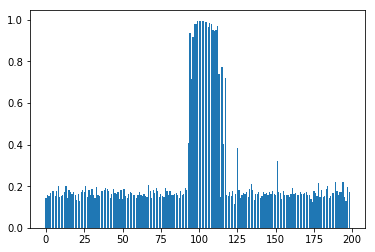

In [490]:
test_pred = dl_model(valid_x)
plt.bar(left = range(199), height = test_pred[10])
plt.show()

In [340]:
def h_tune_model(x_train, y_train, x_test, y_test, batch_size = 32, lr = 0.01, epoch_size = 500, n_h = 1000):
    train_loss = []
    valid_loss = []
    n_in, n_out= x_train.shape[1], 199
    model = nn.Sequential(nn.Linear(n_in, n_h),
                        nn.Sigmoid(), 
                        nn.Linear(n_h, n_out), 
                        nn.Sigmoid()
                        )
    criterion = nn.CrossEntropyLoss()
    optim = torch.optim.SGD(model.parameters(), lr = lr)

    for epoch in range(epoch_size):
        for batch_x, batch_y in batch(x_train, y_train, batch_size):
            y_pred = model(batch_x)

            # get the loss function
            loss = criterion(y_pred, batch_y)
#             if epoch % 10 == 0:
#                 print("epoch %s loss value: %.7f"%(epoch, loss.item()))

            # zero the gradient
            optim.zero_grad()

            # back propogate
            loss.backward()

            # update the parameter
            optim.step()
        if epoch % 10 == 0:
            train_loss.append(loss.item())
            test_pred = model(x_test)
            l = criterion(test_pred, y_test)
            valid_loss.append(l)
#             print("epoch %s loss value: %.7f"%(epoch, loss.item()))
        if epoch % 100 == 0:
            print(epoch)
    return model, train_loss, valid_loss



## Tuning the epoch size for further analysis

In [344]:
dl_model, train_loss, valid_loss = h_tune_model(model_x, model_y, valid_x, valid_y, batch_size = 32, lr = 0.01, epoch_size = 1000, n_h = 1000)

0
100
200
300
400
500
600
700
800
900


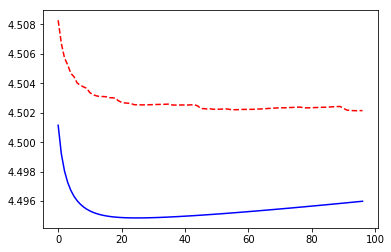

In [349]:
n = 3
plt.plot(range(len(train_loss) - n), train_loss[n:], color = 'b')
plt.plot(range(len(train_loss) - n), valid_loss[n:], linestyle = 'dashed', color = 'red')
plt.show()
# based on the image below, I decided to choose epoch size of 300 to test different scenarios for now

### Tuning the batch size

In [365]:
batch_size = [16, 32, 64, 128, 256]
for b in batch_size:
    exec("_, train_loss_%s , valid_loss_%s = h_tune_model(model_x, model_y, valid_x, valid_y, batch_size = b, lr = 0.01, epoch_size = 300, n_h = 1000)" % (b, b))

0
100
200
0
100
200
0
100
200
0
100
200
0
100
200


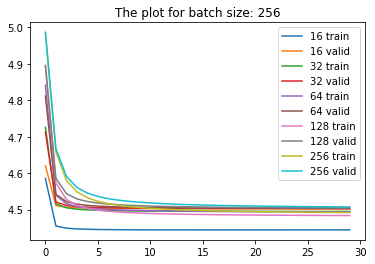

In [387]:
for b in batch_size:
    exec("plt.plot(range(len(train_loss_%s)), train_loss_%s, label = '%s train')"%(b, b, b))
    exec("plt.plot(range(len(valid_loss_%s)), valid_loss_%s, label = '%s valid')"%(b, b, b))
    plt.title("The plot for batch size: "+str(b))
plt.legend()
plt.show()
# The model shows that the smaller batch_size is better

### Tuning the number of hidden layer

In [389]:
def h_tune_model_l2(x_train, y_train, x_test, y_test, batch_size = 32, 
                 lr = 0.01, epoch_size = 500, n_h1 = 1000, n_h2 = 500):
    train_loss = []
    valid_loss = []
    n_in, n_out= x_train.shape[1], 199
    model = nn.Sequential(nn.Linear(n_in, n_h1),
                        nn.Sigmoid(), 
                        nn.Linear(n_h1, n_h2),
                        nn.Sigmoid(),
                        nn.Linear(n_h2, n_out), 
                        nn.Sigmoid()
                        )
    criterion = nn.CrossEntropyLoss()
    optim = torch.optim.SGD(model.parameters(), lr = lr)

    for epoch in range(epoch_size):
        for batch_x, batch_y in batch(x_train, y_train, batch_size):
            y_pred = model(batch_x)

            # get the loss function
            loss = criterion(y_pred, batch_y)
#             if epoch % 10 == 0:
#                 print("epoch %s loss value: %.7f"%(epoch, loss.item()))

            # zero the gradient
            optim.zero_grad()

            # back propogate
            loss.backward()

            # update the parameter
            optim.step()
        if epoch % 10 == 0:
            train_loss.append(loss.item())
            test_pred = model(x_test)
            l = criterion(test_pred, y_test)
            valid_loss.append(l)
#             print("epoch %s loss value: %.7f"%(epoch, loss.item()))
        if epoch % 100 == 0:
            print(epoch)
    return model, train_loss, valid_loss

_, train_loss_l2, valid_loss_l2 = h_tune_model_l2(model_x, model_y, valid_x, valid_y, batch_size = 32, lr = 0.01, epoch_size = 300)

0
100
200


In [398]:
def h_tune_model_l3(x_train, y_train, x_test, y_test, batch_size = 32, 
                 lr = 0.01, epoch_size = 500, n_h1 = 1000, n_h2 = 500, n_h3 = 300):
    train_loss = []
    valid_loss = []
    n_in, n_out= x_train.shape[1], 199
    model = nn.Sequential(nn.Linear(n_in, n_h1),
                        nn.Sigmoid(), 
                        nn.Linear(n_h1, n_h2),
                        nn.Sigmoid(),
                        nn.Linear(n_h2, n_h3),
                        nn.Sigmoid(),
                        nn.Linear(n_h3, n_out), 
                        nn.Sigmoid()
                        )
    criterion = nn.CrossEntropyLoss()
    optim = torch.optim.SGD(model.parameters(), lr = lr)

    for epoch in range(epoch_size):
        for batch_x, batch_y in batch(x_train, y_train, batch_size):
            y_pred = model(batch_x)

            # get the loss function
            loss = criterion(y_pred, batch_y)
#             if epoch % 10 == 0:
#                 print("epoch %s loss value: %.7f"%(epoch, loss.item()))

            # zero the gradient
            optim.zero_grad()

            # back propogate
            loss.backward()

            # update the parameter
            optim.step()
        if epoch % 10 == 0:
            train_loss.append(loss.item())
            test_pred = model(x_test)
            l = criterion(test_pred, y_test)
            valid_loss.append(l)
#             print("epoch %s loss value: %.7f"%(epoch, loss.item()))
        if epoch % 100 == 0:
            print(epoch)
    return model, train_loss, valid_loss

_, train_loss_l3, valid_loss_l3 = h_tune_model_l3(model_x, model_y, valid_x, valid_y, batch_size = 32, lr = 0.01, epoch_size = 300)

0
100
200


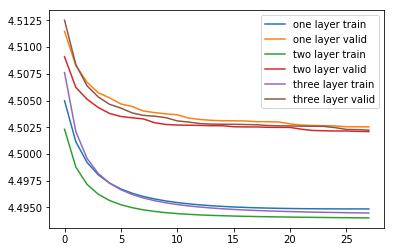

In [402]:
plt.plot(range(len(train_loss[2:30])), train_loss[2:30], label = 'one layer train')
plt.plot(range(len(train_loss[2:30])), valid_loss[2:30], label = 'one layer valid')
plt.plot(range(len(train_loss_l2[2:])), train_loss_l2[2:], label = 'two layer train')
plt.plot(range(len(valid_loss_l2[2:])), valid_loss_l2[2:], label = 'two layer valid')
plt.plot(range(len(train_loss_l3[2:])), train_loss_l3[2:], label = 'three layer train')
plt.plot(range(len(train_loss_l3[2:])), valid_loss_l3[2:], label = 'three layer valid')

plt.legend()
plt.show()
# apparently two layer is better than three layer 